# Analyzing Paris AirBnB listings data. 
The following notebook will address some key questions about Paris AirBnB listings data. 

1. Explore Data
2. Address any issues with cleanliness and tidiness issues. 
3. Answer major questions about data. 
    1. Breakdown of listings by room type.  
    2. What is the median price of a listing by district and room type. 
    3. What is the average difference in a listing price between superhost and non-superhost status for each room type and district? 
    4. Of user available options on the website- which option more strongly influences price? (Regression problem- idenfying predictor variables). 

### Preliminary: Import libraries.

In [1428]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import re
import csv
import unidecode
import wptools
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer, r2_score


%matplotlib inline 

#set default style
sns.set_style("whitegrid", {'font.sans-serif': 'DejaVu Sans'})



### Preliminary: Import All Data

> The data were obtained from Inside AirBnB [here](http://insideairbnb.com/get-the-data.html) which were made available under a Creative Commons CC0 1.0 Universal (CC0 1.0) "Public Domain Dedication" license. They were obtained June 10, 2019. 

In [1665]:
#import the data
listings = pd.read_csv('Data/listings.csv', encoding='utf-8')
cal = pd.read_csv('Data/calendar.csv')

### 1. Explore Data

In [1430]:
#get general info
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59126 entries, 0 to 59125
Columns: 106 entries, id to reviews_per_month
dtypes: float64(23), int64(21), object(62)
memory usage: 47.8+ MB


In [1431]:
#get column names
listings.columns

for i,v in enumerate(listings):
    print i,v

0 id
1 listing_url
2 scrape_id
3 last_scraped
4 name
5 summary
6 space
7 description
8 experiences_offered
9 neighborhood_overview
10 notes
11 transit
12 access
13 interaction
14 house_rules
15 thumbnail_url
16 medium_url
17 picture_url
18 xl_picture_url
19 host_id
20 host_url
21 host_name
22 host_since
23 host_location
24 host_about
25 host_response_time
26 host_response_rate
27 host_acceptance_rate
28 host_is_superhost
29 host_thumbnail_url
30 host_picture_url
31 host_neighbourhood
32 host_listings_count
33 host_total_listings_count
34 host_verifications
35 host_has_profile_pic
36 host_identity_verified
37 street
38 neighbourhood
39 neighbourhood_cleansed
40 neighbourhood_group_cleansed
41 city
42 state
43 zipcode
44 market
45 smart_location
46 country_code
47 country
48 latitude
49 longitude
50 is_location_exact
51 property_type
52 room_type
53 accommodates
54 bathrooms
55 bedrooms
56 beds
57 bed_type
58 amenities
59 square_feet
60 price
61 weekly_price
62 monthly_price
63 security_

In [1433]:
#see how many room types
listings.room_type.value_counts()

Entire home/apt    51132
Private room        7527
Shared room          467
Name: room_type, dtype: int64

In [1434]:
#check for any missing values
listings.room_type.isna().sum()

0

In [1435]:
#see the accomodates numbers
listings.accommodates.value_counts()

2     28382
4     14999
3      5782
6      3251
1      2771
5      2419
8       609
7       493
10      148
9       109
12       55
16       35
11       29
15       17
14       15
13       11
17        1
Name: accommodates, dtype: int64

In [1436]:
#check for any missing values
listings.accommodates.isna().sum()

0

In [1437]:
#see bathroom count
listings.bathrooms.value_counts()

1.0     51003
1.5      3332
2.0      3129
2.5       589
0.5       344
3.0       341
0.0       103
3.5        77
4.0        50
5.0        23
7.0        22
4.5        22
6.0         8
50.0        7
5.5         5
8.0         4
26.0        1
6.5         1
7.5         1
Name: bathrooms, dtype: int64

In [1438]:
#check for any missing values
listings.bathrooms.isna().sum()

#64 are missing bathrooms? 

64

In [1440]:
#Explore listings with missing bathrooms. 
listings[listings.bathrooms.isna()][['beds', 'bedrooms', 'listing_url', 'property_type']].head(10)

,beds,bedrooms,listing_url,property_type
57,1.0,1.0,https://www.airbnb.com/rooms/30969,Apartment
87,1.0,1.0,https://www.airbnb.com/rooms/41745,Apartment
241,1.0,1.0,https://www.airbnb.com/rooms/161703,Apartment
249,1.0,1.0,https://www.airbnb.com/rooms/168217,Apartment
306,1.0,1.0,https://www.airbnb.com/rooms/206216,Apartment
327,3.0,1.0,https://www.airbnb.com/rooms/221844,Apartment
358,1.0,1.0,https://www.airbnb.com/rooms/246647,Apartment
370,1.0,1.0,https://www.airbnb.com/rooms/255958,Apartment
382,3.0,2.0,https://www.airbnb.com/rooms/264167,Apartment
393,NaN,2.0,https://www.airbnb.com/rooms/272269,Apartment


In [1441]:
#see bedroom count
listings.bedrooms.value_counts()

1.0     34378
0.0     11911
2.0      9200
3.0      2758
4.0       658
5.0       126
6.0        21
7.0        12
50.0        7
10.0        2
38.0        1
9.0         1
Name: bedrooms, dtype: int64

In [1442]:
#check for any missing values
listings.bedrooms.isna().sum()

51

In [1443]:
#see bed counts
listings.beds.value_counts()

1.0     31451
2.0     16973
3.0      5279
4.0      2210
0.0      1548
5.0       805
6.0       363
7.0        97
8.0        60
16.0       17
9.0        15
10.0       12
11.0        7
12.0        6
50.0        4
13.0        2
15.0        1
25.0        1
20.0        1
17.0        1
23.0        1
Name: beds, dtype: int64

In [1444]:
#check for any missing values
listings.beds.isna().sum()

#272 that do not have any information about beds
#might be interesting to look into these to see if this is just an error or if there are actually no beds...

272

In [1445]:
#expore these ones that are missing beds
# if they have a bedroom listed then they surely have a bed.. what about the ones where bedrooms were also NA
listings[listings.beds.isna()][['room_type','listing_url', 'bedrooms']]
listings[listings.beds.isna() &listings.bedrooms.isna() ][['beds','room_type','listing_url', 'bedrooms']].head(10)



,beds,room_type,listing_url,bedrooms
6715,NaN,Entire home/apt,https://www.airbnb.com/rooms/3762925,NaN
9110,NaN,Entire home/apt,https://www.airbnb.com/rooms/5459866,NaN
27417,NaN,Private room,https://www.airbnb.com/rooms/16478515,NaN
28012,NaN,Private room,https://www.airbnb.com/rooms/17012723,NaN
34643,NaN,Entire home/apt,https://www.airbnb.com/rooms/20553688,NaN
41909,NaN,Private room,https://www.airbnb.com/rooms/24915942,NaN
41910,NaN,Private room,https://www.airbnb.com/rooms/24915948,NaN
41911,NaN,Private room,https://www.airbnb.com/rooms/24915951,NaN
47423,NaN,Entire home/apt,https://www.airbnb.com/rooms/28176325,NaN
57457,NaN,Entire home/apt,https://www.airbnb.com/rooms/33879791,NaN


In [1446]:
#see minimum night counts
listings.minimum_nights.value_counts()

2       15854
1       14386
3       11401
4        5387
5        4293
7        2366
6        1564
30       1169
10        453
14        267
15        258
91        257
8         183
20        166
90        161
28        124
60         75
12         74
9          62
21         57
13         50
180        42
25         41
120        33
31         32
92         26
365        25
270        20
50         19
45         19
        ...  
290         1
255         1
74          1
330         1
190         1
61          1
700         1
156         1
123         1
58          1
89          1
57          1
600         1
56          1
87          1
310         1
182         1
85          1
340         1
308         1
244         1
84          1
275         1
95          1
240         1
366         1
4364        1
110         1
9999        1
400         1
Name: minimum_nights, Length: 101, dtype: int64

In [1447]:
#check for missing values
listings.minimum_nights.isna().sum()

0

In [1448]:
#see property type count
listings.property_type.value_counts()
#there are some interesting listing types! 

Apartment                 53280
Condominium                1670
Loft                       1173
Boutique hotel              980
Serviced apartment          482
House                       448
Bed and breakfast           296
Townhouse                   232
Hotel                       141
Other                       111
Guesthouse                   99
Hostel                       58
Guest suite                  43
Aparthotel                   29
Tiny house                   27
Boat                         16
Houseboat                    10
Villa                         9
Casa particular (Cuba)        4
Cave                          3
Castle                        2
Earth house                   2
Nature lodge                  2
Dorm                          1
Treehouse                     1
Bungalow                      1
Igloo                         1
Resort                        1
Cabin                         1
Barn                          1
Cottage                       1
In-law  

In [1449]:
#check for any missing values 
listings.property_type.isna().sum()

0

In [1450]:
#how many unique listings at the time of download?
listings.id.nunique()

59126

In [1452]:
#explore neighbourhoods_cleansed
listings.neighbourhood_cleansed.value_counts()

Buttes-Montmartre      6700
Popincourt             5779
Vaugirard              4404
Entrepôt               4154
Batignolles-Monceau    3995
Ménilmontant           3454
Buttes-Chaumont        3322
Passy                  2959
Temple                 2809
Opéra                  2723
Reuilly                2401
Observatoire           2250
Gobelins               2119
Panthéon               1997
Bourse                 1996
Hôtel-de-Ville         1903
Luxembourg             1775
Palais-Bourbon         1694
Élysée                 1530
Louvre                 1162
Name: neighbourhood_cleansed, dtype: int64

## 2. Clean and Tidy Data
> 1. Perform some tidying on the listings df - to be used for data visualization. 
    1. Remove some random columns that will not be used in this analysis and remove columns with All NAs.
    2. Create district column using the cleansed neighbourhoods
        A. Use the wptools API to get the neighbourhoods by districts table on the Wiki Page. 
    3. Clean up odd bedroom numbers and infer any missing.  
    4. Clean up odd bathrooms and infer any missing.
    5. Infer missing beds. 
    6. Clean up price. 
> 2. Join the calendar df with the listings df to get the price of each listing at a certain date.
    Note***: Will still retain the original listings df for data visualization purposes. 
    1. Remove some columns not interested in
    2. Create day of the week using the date in cal df. 
    3. Select only unique days (Monday - Friday for each listing_id x month X year)
    4. Clean up adjusted price.


In [1666]:
#remove some columns that are uninformative to the questions that are being asked
regexs = ['calculated', 'require',  'scrape', 'availability', 'business']

for reg in regexs:
    listings = listings[listings.columns.drop(list(listings.filter(regex=reg)))] 

In [1667]:
#remove columns that have all missing values 
listings.columns[listings.isnull().mean()==1].tolist()

[u'thumbnail_url',
 u'medium_url',
 u'xl_picture_url',
 u'host_acceptance_rate',
 u'neighbourhood_group_cleansed']

In [1668]:
#remove columns that have all missing values 
listings = listings.drop(listings.columns[listings.isnull().mean()==1].tolist(), axis=1)

In [1669]:
#check value counts to make sure no obvious problems
listings.bedrooms.value_counts()

1.0     34378
0.0     11911
2.0      9200
3.0      2758
4.0       658
5.0       126
6.0        21
7.0        12
50.0        7
10.0        2
38.0        1
9.0         1
Name: bedrooms, dtype: int64

In [1670]:
#deal with weird bedroom counts
#due to an odd hotel listing
listings.loc[listings['bedrooms'] >37 , 'bedrooms'] = 1



In [1671]:
#make sure it worked
listings.bedrooms.value_counts()

1.0     34386
0.0     11911
2.0      9200
3.0      2758
4.0       658
5.0       126
6.0        21
7.0        12
10.0        2
9.0         1
Name: bedrooms, dtype: int64

In [1672]:
#look at beds and bathrooms
listings.beds.value_counts(), listings.bathrooms.value_counts(), 

(1.0     31451
 2.0     16973
 3.0      5279
 4.0      2210
 0.0      1548
 5.0       805
 6.0       363
 7.0        97
 8.0        60
 16.0       17
 9.0        15
 10.0       12
 11.0        7
 12.0        6
 50.0        4
 13.0        2
 15.0        1
 25.0        1
 20.0        1
 17.0        1
 23.0        1
 Name: beds, dtype: int64, 1.0     51003
 1.5      3332
 2.0      3129
 2.5       589
 0.5       344
 3.0       341
 0.0       103
 3.5        77
 4.0        50
 5.0        23
 7.0        22
 4.5        22
 6.0         8
 50.0        7
 5.5         5
 8.0         4
 26.0        1
 6.5         1
 7.5         1
 Name: bathrooms, dtype: int64)

In [1673]:
listings[listings['beds'] >37][['listing_url','summary', 'bedrooms']]
#looks like a listing for a hotel, reassign based on the description given in the url
listings.loc[listings['beds'] >37 , 'beds'] = 1
listings.loc[listings['bathrooms'] >37 , 'bathrooms'] = 1

In [1674]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59126 entries, 0 to 59125
Data columns (total 85 columns):
id                             59126 non-null int64
listing_url                    59126 non-null object
name                           59055 non-null object
summary                        56752 non-null object
space                          40795 non-null object
description                    58519 non-null object
experiences_offered            59126 non-null object
neighborhood_overview          35993 non-null object
notes                          18633 non-null object
transit                        38647 non-null object
access                         28329 non-null object
interaction                    29085 non-null object
house_rules                    28684 non-null object
picture_url                    59126 non-null object
host_id                        59126 non-null int64
host_url                       59126 non-null object
host_name                      59110 non-null

In [1675]:
#still missing information on bedrooms, look into that here
listings[listings.bedrooms.isna()]

,id,listing_url,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,jurisdiction_names,instant_bookable,cancellation_policy,reviews_per_month
6,10586,https://www.airbnb.com/rooms/10586,Montmartre Studio 7,LONG TERM RENTAL Available The studio is situ...,The studio is an open living space measuring 2...,LONG TERM RENTAL Available The studio is situ...,none,"Montmartre, the neighborhood surrounding the s...",NaN,"The studio can be easily accessed by the RER, ...",...,10.0,10.0,10.0,9.0,9.0,NaN,{PARIS},f,strict_14_with_grace_period,0.37
7,10588,https://www.airbnb.com/rooms/10588,Montmartre Studio 10,LONG TERM RENTAL 12 MONTHS - 9 MONTHS for STU...,The studio has lots of natural light and has b...,LONG TERM RENTAL 12 MONTHS - 9 MONTHS for STU...,none,"Montmartre, the neighborhood surrounding the s...",NaN,The studio can be easily accessed by the RER...,...,10.0,10.0,10.0,9.0,10.0,NaN,{PARIS},f,strict_14_with_grace_period,0.16
12,11487,https://www.airbnb.com/rooms/11487,"Old Paris,brand new aparment.",NaN,"Brand new renovated studio with living room, b...","Brand new renovated studio with living room, b...",none,NaN,NaN,NaN,...,10.0,10.0,10.0,10.0,9.0,NaN,{PARIS},f,strict_14_with_grace_period,0.02
106,50738,https://www.airbnb.com/rooms/50738,Montmartre Studio 8,LONG TERM RENTALS: 12 MONTHS - 9 MONTHS for ST...,The studio is situated on a quiet street and i...,LONG TERM RENTALS: 12 MONTHS - 9 MONTHS for ST...,none,"Montmartre, the neighborhood surrounding the s...",NaN,The studio can be easily accessed by the RER...,...,10.0,10.0,10.0,8.0,9.0,NaN,{PARIS},f,strict_14_with_grace_period,0.33
397,273662,https://www.airbnb.com/rooms/273662,Charming Studio - Montmartre (20m2),NaN,Available mostly on weekends In the special ar...,Available mostly on weekends In the special ar...,none,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,{PARIS},f,moderate,NaN
668,446536,https://www.airbnb.com/rooms/446536,Studio rue saint honoré.,NaN,"Charmant studio, situé rue st honoré, au centr...","Charmant studio, situé rue st honoré, au centr...",none,NaN,NaN,NaN,...,9.0,9.0,9.0,9.0,9.0,NaN,{PARIS},f,flexible,0.28
885,537443,https://www.airbnb.com/rooms/537443,Lovely Studio Paris / Eiffel Tower,NaN,Lovely studio of 14 m² (squared meters) did up...,Lovely studio of 14 m² (squared meters) did up...,none,NaN,NaN,NaN,...,10.0,10.0,9.0,10.0,9.0,NaN,{PARIS},f,strict_14_with_grace_period,1.91
1024,571966,https://www.airbnb.com/rooms/571966,Sunny Loft Belleville/Menilmontant,NaN,This artist's loft is situated in the historic...,This artist's loft is situated in the historic...,none,NaN,NaN,NaN,...,9.0,10.0,10.0,9.0,9.0,NaN,{PARIS},f,strict_14_with_grace_period,0.06
1142,605371,https://www.airbnb.com/rooms/605371,Charmant studio Saint Germain,Récemment rénové au coeur de Saint Germain des...,Récemment rénové au coeur de Saint Germain des...,Récemment rénové au coeur de Saint Germain des...,none,NaN,NaN,NaN,...,9.0,10.0,10.0,10.0,9.0,NaN,{PARIS},t,strict_14_with_grace_period,2.94
2113,1053353,https://www.airbnb.com/rooms/1053353,Bastille-Froment Street Cosy studio,Nice studio with all the base amenities of a h...,This studio apartment is situated between the ...,Nice studio with all the base amenities of a h...,none,The apartment is located nearby of the crossro...,ARRIVALS DETAILS & CHECK IN APPOINTMENT : It's...,The apartment is conveniently located near sub...,...,8.0,9.0,9.0,10.0,7.0,NaN,{PARIS},f,flexible,0.16


In [1676]:
#fill in the bedrooms using information from other columns
listings[listings.bedrooms.isna()][['beds', 'summary', 'room_type']]

,beds,summary,room_type
6,1.0,LONG TERM RENTAL Available The studio is situ...,Entire home/apt
7,1.0,LONG TERM RENTAL 12 MONTHS - 9 MONTHS for STU...,Entire home/apt
12,1.0,NaN,Entire home/apt
106,1.0,LONG TERM RENTALS: 12 MONTHS - 9 MONTHS for ST...,Entire home/apt
397,1.0,NaN,Entire home/apt
668,1.0,NaN,Entire home/apt
885,1.0,NaN,Entire home/apt
1024,1.0,NaN,Entire home/apt
1142,1.0,Récemment rénové au coeur de Saint Germain des...,Entire home/apt
2113,1.0,Nice studio with all the base amenities of a h...,Entire home/apt


In [1677]:
#set 0 bedrooms for studios based on summary or name of listing
listings['bedrooms'] = np.where(listings['bedrooms'].isna() &listings['name'].str.contains('studio|STUDIO', flags=re.IGNORECASE,regex=False),0,listings['bedrooms'])
listings['bedrooms'] = np.where(listings['bedrooms'].isna() &listings['summary'].str.contains('studio|STUDIO', flags=re.IGNORECASE,regex=False),0,listings['bedrooms'])
#assume the remaining missing are just studios
listings['bedrooms'] = np.where(listings['bedrooms'].isna(),0,listings['bedrooms'])


In [1678]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59126 entries, 0 to 59125
Data columns (total 85 columns):
id                             59126 non-null int64
listing_url                    59126 non-null object
name                           59055 non-null object
summary                        56752 non-null object
space                          40795 non-null object
description                    58519 non-null object
experiences_offered            59126 non-null object
neighborhood_overview          35993 non-null object
notes                          18633 non-null object
transit                        38647 non-null object
access                         28329 non-null object
interaction                    29085 non-null object
house_rules                    28684 non-null object
picture_url                    59126 non-null object
host_id                        59126 non-null int64
host_url                       59126 non-null object
host_name                      59110 non-null

In [1679]:
listings.bedrooms.value_counts()

1.0     34386
0.0     11962
2.0      9200
3.0      2758
4.0       658
5.0       126
6.0        21
7.0        12
10.0        2
9.0         1
Name: bedrooms, dtype: int64

In [1680]:
#now look at beds
listings[listings.beds.isna()][['summary', 'listing_url', 'bathrooms', 'bedrooms', 'accommodates']].head(20)

,summary,listing_url,bathrooms,bedrooms,accommodates
393,NaN,https://www.airbnb.com/rooms/272269,NaN,2.0,4
841,NaN,https://www.airbnb.com/rooms/526351,NaN,1.0,2
1152,Family flat in an ancient building including a...,https://www.airbnb.com/rooms/608622,NaN,3.0,5
1234,NaN,https://www.airbnb.com/rooms/634771,NaN,1.0,2
1575,NaN,https://www.airbnb.com/rooms/780942,NaN,1.0,1
1625,"A 2 pas du Trocadéro, du Palais de Chaillot et...",https://www.airbnb.com/rooms/797208,1.0,1.0,2
1638,NaN,https://www.airbnb.com/rooms/799369,NaN,1.0,1
1687,"Bright studio in the Marais, near bastille. 4t...",https://www.airbnb.com/rooms/817391,NaN,1.0,2
1846,Joli appartement 2 pièces dans le 18ème arrond...,https://www.airbnb.com/rooms/891753,NaN,1.0,2
1942,Appartement meublé et aménagé par un architect...,https://www.airbnb.com/rooms/946440,NaN,2.0,2


In [1681]:
listings[listings.beds.isna()][['summary', 'listing_url', 'bathrooms', 'bedrooms', 'accommodates']].accommodates.value_counts()

2     171
4      40
1      29
3      23
6       4
5       4
16      1
Name: accommodates, dtype: int64

In [1682]:
#if listing accomodates 1 there must be only 1 bed
listings.loc[(listings['accommodates'] == 1), 'beds'] = 1
#if there is 1 bedroom and accomodates 2 there must be at least 1 bed
listings.loc[((listings['accommodates'] == 2) & (listings['bedrooms'] == 1)) , 'beds'] = 1
#if there are 2 bedrooms and accomodates 4 there must be at least 2 beds
listings.loc[((listings['accommodates'] == 4) & (listings['bedrooms'] == 2)) , 'beds'] = 2
#if there are 3 bedrooms and accomodates 5 there must be at least 3 beds
accom = [5,6]
listings.loc[((listings['accommodates'].isin(accom)) & (listings['bedrooms'] == 3)) , 'beds'] = 3


In [1683]:
listings.beds.isna().sum()

82

In [1684]:
#assign 1 bed to these ones missing 
listings['beds'] = np.where(listings['beds'].isna(), 1, listings['beds'])

In [1685]:
#check to make sure it worked
listings.beds.isna().sum()

0

In [1686]:
#deal with missing bathrooms (there should be at least 1 bathroom)
listings[listings.bathrooms.isna()][['listing_url']]

,listing_url
57,https://www.airbnb.com/rooms/30969
87,https://www.airbnb.com/rooms/41745
241,https://www.airbnb.com/rooms/161703
249,https://www.airbnb.com/rooms/168217
306,https://www.airbnb.com/rooms/206216
327,https://www.airbnb.com/rooms/221844
358,https://www.airbnb.com/rooms/246647
370,https://www.airbnb.com/rooms/255958
382,https://www.airbnb.com/rooms/264167
393,https://www.airbnb.com/rooms/272269


In [1687]:
#assign a bathroom
listings.loc[listings['bathrooms'].isna(), 'bathrooms'] = 1

In [1688]:
#assign 1 bathroom to these ones missing 
listings['bathrooms'] = np.where(listings['bathrooms'].isna(), 1, listings['bathrooms'])

In [1689]:
#make sure it worked
listings.bathrooms.isna().sum()

0

In [1690]:
# Assign districts. 
#get list of neighborhoods by districts from the Wikipedia page
page=wptools.page('Arrondissements of Paris').get_parse()
text = page.data['wikitext']
text.find('=== Arrondissements ===') #beginning of table
text.find('1936') #end of table 
#slice the text
wikitext=text[text.find('=== Arrondissements ==='):text.find('1936')] 

en.wikipedia.org (parse) Arrondissements of Paris
Arrondissements of Paris (en) data
{
  infobox: <dict(19)> area_footnotes, population_density_km2, subd...
  pageid: 1175882
  parsetree: <str(24459)> <root><template><title>Infobox settlemen...
  requests: <list(1)> parse
  title: Arrondissements of Paris
  wikibase: Q679388
  wikidata_url: https://www.wikidata.org/wiki/Q679388
  wikitext: <str(16064)> {{Infobox settlement<!-- See Template:Inf...
}


In [1691]:
#save the table to a csv file
import unidecode
import re
lines = wikitext.split('[[') 

entries=[]

for line in lines:
    if line[0].isdigit():
        table = line.split("||")
        dist = table[0].split("|")
        num_dist = re.findall("\d+", dist[0])[0]
        nbhd = table[1].encode('utf-8')
        entry= num_dist, nbhd
        entries.append(entry)
        
 
file = open('paris_districts.csv', "wb")
writer=csv.writer(file)
writer.writerows(entries)
file.close()


In [1692]:
nbhds = pd.read_csv("paris_districts.csv", header=None, names=['district2', 'neighbourhood_cleansed'], encoding="utf-8")
nbhds.district2 = nbhds.district2.astype(str)
nbhds['neighbourhood_cleansed'] = nbhds['neighbourhood_cleansed'].str.strip()

In [1693]:
nbhds['neighbourhood_cleansed'] = np.where(nbhds['neighbourhood_cleansed'] == 'Butte-Montmartre','Buttes-Montmartre',  nbhds['neighbourhood_cleansed'])

In [1694]:
#do a join to match the neighbourhoods to the districts
list2 = listings.join(nbhds.set_index("neighbourhood_cleansed"), on="neighbourhood_cleansed")


In [1695]:
#check to see it worked
list2[['neighbourhood','neighbourhood_cleansed', 'district2', 'zipcode']]
list2.district2.isna().sum()

0

In [1696]:
#check new value counts
list2.district2.value_counts()
list2.district2.isna().sum()

0

In [1697]:
#check on the shape
list2.shape,listings.shape

((59126, 86), (59126, 85))

In [1698]:
#Clean up the price column. 
list2.price.value_counts()

$80.00       2933
$60.00       2895
$70.00       2794
$50.00       2779
$100.00      2486
$90.00       2281
$65.00       1817
$75.00       1777
$120.00      1654
$55.00       1603
$40.00       1497
$45.00       1496
$150.00      1493
$85.00       1306
$110.00      1235
$95.00       1119
$130.00       872
$35.00        844
$200.00       772
$99.00        691
$140.00       623
$69.00        608
$30.00        588
$250.00       572
$79.00        561
$59.00        546
$49.00        514
$180.00       495
$89.00        489
$160.00       456
             ... 
$529.00         1
$3,500.00       1
$505.00         1
$917.00         1
$352.00         1
$363.00         1
$925.00         1
$1,084.00       1
$629.00         1
$797.00         1
$366.00         1
$869.00         1
$545.00         1
$824.00         1
$412.00         1
$646.00         1
$607.00         1
$1,593.00       1
$910.00         1
$684.00         1
$918.00         1
$8,500.00       1
$8,932.00       1
$1,154.00       1
$1,182.00 

In [1699]:
#strip the $ sign and , from the price
list2.price = list2.price.str.replace('$', "")
list2.price = list2.price.str.replace(',', "")

In [1700]:
#filter listings to remove price that is listed as 0 or as null
list3=list2.dropna(subset=['price'], axis=0)

In [1701]:
#check to make sure it worked
list3.price.isnull().sum()

0

In [1702]:
list3.price.value_counts()

80.00      2933
60.00      2895
70.00      2794
50.00      2779
100.00     2486
90.00      2281
65.00      1817
75.00      1777
120.00     1654
55.00      1603
40.00      1497
45.00      1496
150.00     1493
85.00      1306
110.00     1235
95.00      1119
130.00      872
35.00       844
200.00      772
99.00       691
140.00      623
69.00       608
30.00       588
250.00      572
79.00       561
59.00       546
49.00       514
180.00      495
89.00       489
160.00      456
           ... 
646.00        1
775.00        1
261.00        1
528.00        1
910.00        1
1136.00       1
2300.00       1
760.00        1
739.00        1
945.00        1
545.00        1
1448.00       1
1593.00       1
1975.00       1
486.00        1
526.00        1
1426.00       1
401.00        1
925.00        1
238.00        1
640.00        1
1695.00       1
1900.00       1
314.00        1
341.00        1
457.00        1
611.00        1
363.00        1
570.00        1
1584.00       1
Name: price, Length: 677

In [1703]:
#convert to a float
list3['price'] = list3['price'].astype(float)

In [1704]:
list3.price.describe()

count    59126.000000
mean       116.325982
std        167.669754
min          0.000000
25%         59.000000
50%         80.000000
75%        120.000000
max       9379.000000
Name: price, dtype: float64

#### 2. Join the calendar df with the listings df to make new df. 

In [1579]:
#use only adjusted price, drop columns already in the listing df
cal.head()
cal2 = cal.drop(columns=['price', 'minimum_nights', 'maximum_nights'], axis=0)

In [1580]:
cal2.head(20)

,listing_id,date,available,adjusted_price
0,3109,2019-05-07,f,$75.00
1,59508,2019-05-07,f,$99.00
2,59508,2019-05-08,f,$99.00
3,59508,2019-05-09,f,$99.00
4,59508,2019-05-10,f,$99.00
5,59508,2019-05-11,f,$99.00
6,59508,2019-05-12,f,$99.00
7,59508,2019-05-13,f,$99.00
8,59508,2019-05-14,f,$99.00
9,59508,2019-05-15,f,$99.00


In [1581]:
#make a day of the week
cal2.dtypes

listing_id         int64
date              object
available         object
adjusted_price    object
dtype: object

In [1582]:
#convert date to a datetime object
cal2['date'] = pd.to_datetime(cal2['date'])

In [1583]:
cal2.dtypes

listing_id                 int64
date              datetime64[ns]
available                 object
adjusted_price            object
dtype: object

In [1584]:
#get day of the week 
cal2['day_of_week'] = cal2['date'].dt.day_name()

In [1585]:
cal2.shape

(21566475, 5)

In [1586]:
#get month and year
cal2['month'] = cal2['date'].dt.month
cal2['year'] = cal2['date'].dt.year

In [1587]:
#check that it worked
cal2.head(10)

,listing_id,date,available,adjusted_price,day_of_week,month,year
0,3109,2019-05-07,f,$75.00,Tuesday,5,2019
1,59508,2019-05-07,f,$99.00,Tuesday,5,2019
2,59508,2019-05-08,f,$99.00,Wednesday,5,2019
3,59508,2019-05-09,f,$99.00,Thursday,5,2019
4,59508,2019-05-10,f,$99.00,Friday,5,2019
5,59508,2019-05-11,f,$99.00,Saturday,5,2019
6,59508,2019-05-12,f,$99.00,Sunday,5,2019
7,59508,2019-05-13,f,$99.00,Monday,5,2019
8,59508,2019-05-14,f,$99.00,Tuesday,5,2019
9,59508,2019-05-15,f,$99.00,Wednesday,5,2019


In [1588]:
#select only unique rows (listing_id, adjusted_price, day of week and month)
cal3 = cal2.drop_duplicates(subset=['listing_id', 'adjusted_price', 'day_of_week', 'month'], keep=False)

In [1589]:
cal3.shape

(1222010, 7)

In [1590]:
cal3.listing_id.value_counts()[:20]

12602216    365
31322876    361
22273397    359
21555491    359
22159357    357
24821530    357
27918355    357
9982496     357
31951782    357
16969566    356
32075928    355
19468125    355
24839756    355
31017360    355
21889607    355
30729538    355
34275897    354
18802353    353
30559539    353
29509472    353
Name: listing_id, dtype: int64

In [1596]:
#strip the $ sign and , from the price
cal3.adjusted_price = cal3.adjusted_price.str.replace('$', "")
cal3.adjusted_price = cal3.adjusted_price.str.replace(',', "")
cal3.adjusted_price = cal3.adjusted_price.astype(float)

In [1597]:
#join the cal3 to the list2 dataframe (list2 will be used here even though it is missing prices- cal3 might have enough adjusted prices)
list_cal = list2.join(cal3.set_index('listing_id'), on='id')

In [1598]:
list_cal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1243788 entries, 0 to 59125
Data columns (total 92 columns):
id                             1243788 non-null int64
listing_url                    1243788 non-null object
name                           1243506 non-null object
summary                        1177932 non-null object
space                          961819 non-null object
description                    1230402 non-null object
experiences_offered            1243788 non-null object
neighborhood_overview          766104 non-null object
notes                          441618 non-null object
transit                        828189 non-null object
access                         619820 non-null object
interaction                    658993 non-null object
house_rules                    637655 non-null object
picture_url                    1243788 non-null object
host_id                        1243788 non-null int64
host_url                       1243788 non-null object
host_name         

In [1600]:
#how many are missing an adjusted price
list_cal.adjusted_price.isna().sum()

(29384, 0)

In [1601]:
#remove any that are missing adjusted price- there is no way to infer
list_cal2 = list_cal.dropna(subset=['adjusted_price'], axis=0)

In [1602]:
#confirm shape meets expectations
list_cal2.shape

(1214404, 92)

## 3. Visualizations. 
 > 1. What is the room type breakdown.
 > 2. What is the median price by room type and district. 
 > 3. Is there a difference in lisiting price by superhost and non superhost? 

#### 1. What is the room type breakdown? 

In [1705]:
names=list2.room_type.value_counts().index
size = list2.room_type.value_counts()

In [1706]:
names, size

(Index([u'Entire home/apt', u'Private room', u'Shared room'], dtype='object'),
 Entire home/apt    51132
 Private room        7527
 Shared room          467
 Name: room_type, dtype: int64)

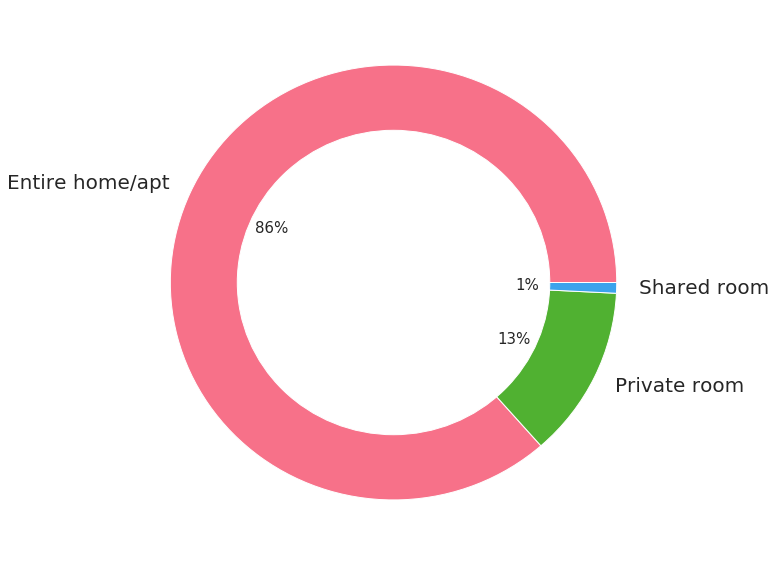

<Figure size 432x288 with 0 Axes>

In [1707]:
plt.figure(figsize=(10, 10))
with sns.color_palette("husl", 3):
    my_circle=plt.Circle( (0,0), 0.7, color='white' )
    #from palettable.colorbrewer.qualitative import Paired_8
    patches, texts, autotexts= plt.pie(size, labels=names, autopct='%.0f%%')#colors=Paired_8.hex_colors)
    p=plt.gcf()
    p.gca().add_artist(my_circle)
    
    for t in texts:
        t.set_fontsize(20)
    for t in autotexts:
        t.set_fontsize(15)
         
    plt.show()
    
plt.savefig('room_types.png')

### 2. What is the median listing price by room type and district? 

In [1708]:
list2['price'] = list2.price.astype(float)

In [1709]:
district_price = list2.groupby('district2')['price'].median().sort_values(ascending=False)
dist = district_price.index.get_level_values(0)

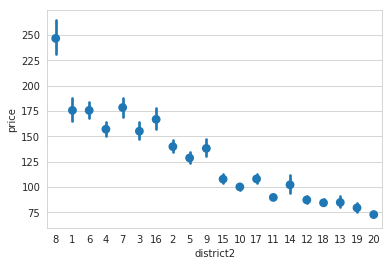

In [1710]:
sns.pointplot(x="district2", y="price",data=list2, dodge= True, order=dist,
                        join=False, alpha=0.75)

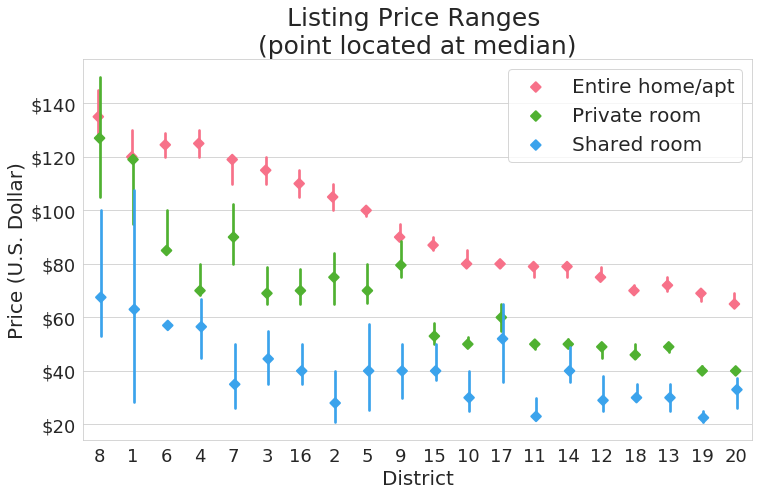

In [1712]:
from numpy import median
#sns.color_palette("husl", 3)
fig=plt.figure(figsize=(12, 7))
with sns.color_palette("husl", 3):
#with sns.color_palette("Paired", 5):
    ax = sns.pointplot(x="district2", y="price",hue='room_type', data=list2,estimator=median, dodge= True, order=dist,
                       markers=["D", "D", "D"], join=False, alpha=0.75, legend_out=True)
    fmt = '${x:,.0f}'
    tick = mtick.StrMethodFormatter(fmt)
    ax.yaxis.set_major_formatter(tick)
    ax.legend(loc='upper right', fontsize=20)
    ax.set_xlabel('District',fontsize=20)
    ax.set_ylabel('Price (U.S. Dollar)',fontsize=20)
    ax.tick_params(axis="x", labelsize=18)
    ax.tick_params(axis="y", labelsize=18)
    ax.set_title('Listing Price Ranges \n(point located at median)', fontsize=25)

fig.savefig('list_price_range.png')


### Side Exploration: Private rooms are almost the same price as entire homes in some districts. Why? 
 > From the above plot it seems in district 8 and 9 the median price of a private room is nearly the same as an entire home. This seems very odd to me. Perhaps this is an error. I will take a look into this below. 

In [1713]:
#just look into district 8
priv = list2[list2['room_type'] == 'Private room']
priv_8 = priv[priv['district2'] == '8']

In [1714]:
#look at the urls and visit a few of the pages. 
priv_8[priv_8['price'] <120]['listing_url']

39          https://www.airbnb.com/rooms/22158
1527       https://www.airbnb.com/rooms/763958
2720      https://www.airbnb.com/rooms/1329018
3123      https://www.airbnb.com/rooms/1528100
3525      https://www.airbnb.com/rooms/1827470
5152      https://www.airbnb.com/rooms/3015969
6110      https://www.airbnb.com/rooms/3483434
6386      https://www.airbnb.com/rooms/3597324
7786      https://www.airbnb.com/rooms/4574708
8121      https://www.airbnb.com/rooms/4756704
8924      https://www.airbnb.com/rooms/5323779
9043      https://www.airbnb.com/rooms/5402219
9990      https://www.airbnb.com/rooms/6048843
10072     https://www.airbnb.com/rooms/6088607
10383     https://www.airbnb.com/rooms/6260716
10552     https://www.airbnb.com/rooms/6344411
10827     https://www.airbnb.com/rooms/6473906
11089     https://www.airbnb.com/rooms/6605806
11440     https://www.airbnb.com/rooms/6752421
11933     https://www.airbnb.com/rooms/6909000
12142     https://www.airbnb.com/rooms/6978963
15497     htt

Wow. After investigating some of these private rooms in district 8 it appears that some are so much nicer than the entire rooms/apt in this area. This seems like a really good find! Most people (including myself) are inclined to immediately select the entire home/apt which would remove all of these amazing listings. These lisiting prices are just as much as entire apartments because they are so, so nice but they just share an entrance which immediately downgrades the price. 

This seems like a major find in the data that I can't wait to share with other people. 



### 3. What is the difference in price between super host and non super host listings? 

In [1503]:
#look at difference in avrage price between superhost and non superhost listings by district and room type (for entire or private)
list3 = list2[list2['room_type'] != 'Shared room']
is_sh = list3[list3['host_is_superhost'] == 't']
not_sh = list3[list3['host_is_superhost'] == 'f']

In [1504]:
is_sh_gr=is_sh.groupby(['room_type', 'district2'])['price'].median().reset_index()

In [1505]:
not_sh_gr=not_sh.groupby(['room_type', 'district2'])['price'].median().reset_index()

In [1506]:
price_by_sh_status= is_sh_gr.rename(columns={'price':"is_sh_price"})
price_by_sh_status['not_sh_price'] = not_sh_gr['price']

In [1507]:
price_by_sh_status.head()

,room_type,district2,is_sh_price,not_sh_price
0,Entire home/apt,1,150.0,119.0
1,Entire home/apt,10,95.0,80.0
2,Entire home/apt,11,90.0,75.0
3,Entire home/apt,12,90.0,75.0
4,Entire home/apt,13,84.5,70.0


In [1511]:
#calculate difference in median price
price_by_sh_status['diff'] = price_by_sh_status['is_sh_price'] - price_by_sh_status['not_sh_price']

In [1512]:
#make sure it looks right
price_by_sh_status.sample(10)

,room_type,district2,is_sh_price,not_sh_price,diff
28,Private room,17,60.0,59.0,1.0
9,Entire home/apt,18,85.0,70.0,15.0
15,Entire home/apt,5,120.0,98.0,22.0
14,Entire home/apt,4,131.5,120.0,11.5
5,Entire home/apt,14,90.0,75.0,15.0
17,Entire home/apt,7,149.0,110.0,39.0
38,Private room,8,90.0,130.0,-40.0
18,Entire home/apt,8,150.0,130.0,20.0
29,Private room,18,50.5,45.0,5.5
35,Private room,5,65.0,70.0,-5.0


In [1513]:
#reorder the dataframe to make it acceptable for barh
price_by_sh_status.set_index('district2')

#Use pivot or unstack:
price_2 = price_by_sh_status.pivot(index='district2',columns='room_type',values='diff')

In [1515]:
#make sure it looks right
price_2.head(10)

room_type,Entire home/apt,Private room
district2,,
1,31.0,-30.0
10,15.0,10.0
11,15.0,3.0
12,15.0,9.5
13,14.5,3.0
14,15.0,10.0
15,15.0,15.0
16,36.0,8.0
17,6.0,1.0


<Figure size 1440x1440 with 0 Axes>

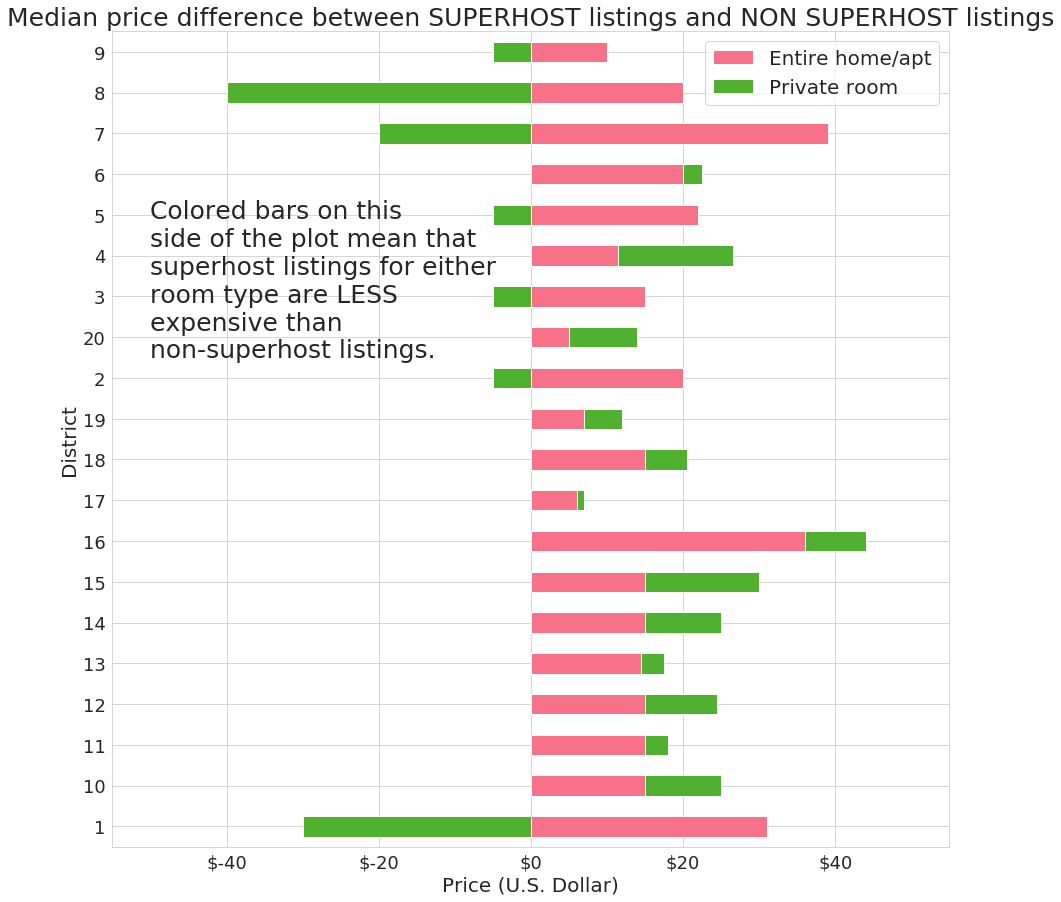

In [1659]:
#make grouped bar plot
# Say, "the default sans-serif font is COMIC SANS"
#plt.rcParams['font.sans-serif'] = "DejaVu Sans"
# Then, "ALWAYS use sans-serif fonts"
#plt.rcParams['font.family'] = "sans-serif"

plt.figure(figsize=(20, 20))
#ax = sns.barplot(x="district", y="diff", hue="room_type", data=price_by_sh_status)
#plt.xticks(rotation=90)
with sns.color_palette("husl", 3):
    ax= price_2.plot(kind='barh', figsize=(15,15), xlim=(-55,55), stacked=True)
    #plt.barh(y='district', width='diff', hue='room_type', data=price_by_sh_status)
    ax.get_legend().set_title("")
    ax.set_ylabel("District", fontname="DejaVu Sans", fontsize=20)
    ax.set_xlabel("Price Difference (U.S. Dollar)", fontname="DejaVu Sans", fontsize=20)
    fmt = '${x:,.0f}'
    tick = mtick.StrMethodFormatter(fmt)
    ax.xaxis.set_major_formatter(tick)
    ax.set_ylabel('District',fontsize=20)
    ax.set_xlabel('Price (U.S. Dollar)',fontsize=20)
    ax.tick_params(axis="x", labelsize=18)
    ax.tick_params(axis="y", labelsize=18)
    ax.legend(loc='upper right', fontsize=20)
    ax.annotate('Colored bars on this \nside of the plot mean that \nsuperhost listings for either \nroom type are LESS \nexpensive than \nnon-superhost listings.', xy=(2, 1),size=25, xytext=(-50, 11.5))
    ax.set_title('Median price difference between SUPERHOST listings and NON SUPERHOST listings', fontsize=25)
    #plt.
    #plt.xlabel('Price Difference (U.S. Dollars)')
    #plt.ylabel('District')

plt.savefig('Superhost_price_diff.png')

In [1517]:
#visualize a different way
new_sh = pd.melt(price_by_sh_status, id_vars=['room_type','district2'], value_vars=['is_sh_price', 'not_sh_price'])
new_sh.head()
#pd.melt(df, id_vars=['A'], value_vars=['B', 'C'])

,room_type,district2,variable,value
0,Entire home/apt,1,is_sh_price,150.0
1,Entire home/apt,10,is_sh_price,95.0
2,Entire home/apt,11,is_sh_price,90.0
3,Entire home/apt,12,is_sh_price,90.0
4,Entire home/apt,13,is_sh_price,84.5


<Figure size 864x504 with 0 Axes>

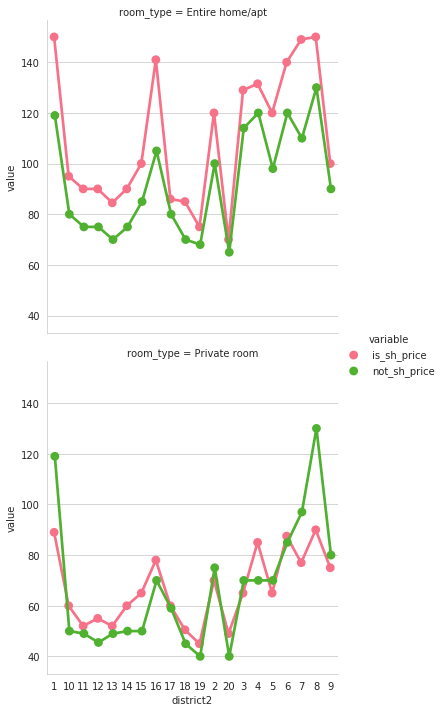

In [1654]:

fig=plt.figure(figsize=(12, 7))
with sns.color_palette("husl", 3):
#with sns.color_palette("Paired", 5):
    ax = sns.catplot(x="district2", y="value",hue='variable',row="room_type", data=new_sh, kind="point", dodge= True) 

ax.savefig('test.png')


## 4.  Regression Question -   Of user available options on the website- which option more strongly influences price? (Regression problem- idenfying predictor variables). 
> Of the options users are able to select- which is the strongest predictor of adjusted_price? In a user mindset- which factor or option is going to be most influential on the price of listings that are displayed to the user?

> Features to evaluate:
    1. minimum nights 
    2. accommodates
    3. room_type 
    4. beds
    5. bedrooms
    6. month
    7. day_of_week
    8. host is superhost
    9. instant bookable
    10. property type
    11. neighbourhood cleansed
    


In [1520]:
#get the first 20 listing_ids
cal3.listing_id.value_counts()[:10]

12602216    365
31322876    361
22273397    359
21555491    359
22159357    357
24821530    357
27918355    357
9982496     357
31951782    357
16969566    356
Name: listing_id, dtype: int64

In [1524]:
#confirm adjusted_price of each listing varies by day_of_week and month
cal3[cal3['listing_id'] == 12602216]['adjusted_price'].value_counts()

$129.00    9
$119.00    7
$106.00    7
$144.00    7
$150.00    7
$108.00    7
$117.00    7
$122.00    7
$151.00    7
$127.00    6
$132.00    6
$154.00    6
$126.00    6
$111.00    6
$135.00    6
$98.00     6
$96.00     6
$138.00    6
$116.00    5
$107.00    5
$101.00    5
$156.00    5
$137.00    5
$124.00    5
$145.00    5
$131.00    4
$118.00    4
$105.00    4
$143.00    4
$130.00    4
          ..
$506.00    1
$247.00    1
$232.00    1
$543.00    1
$220.00    1
$81.00     1
$281.00    1
$134.00    1
$248.00    1
$141.00    1
$256.00    1
$259.00    1
$245.00    1
$136.00    1
$211.00    1
$191.00    1
$112.00    1
$161.00    1
$230.00    1
$94.00     1
$173.00    1
$217.00    1
$290.00    1
$278.00    1
$260.00    1
$241.00    1
$209.00    1
$225.00    1
$221.00    1
$233.00    1
Name: adjusted_price, Length: 132, dtype: int64

In [1526]:
cal3[cal3['listing_id'] == 31322876]['adjusted_price'].value_counts()

$528.00      5
$476.00      4
$464.00      4
$571.00      4
$538.00      4
$534.00      4
$469.00      4
$402.00      4
$418.00      4
$557.00      4
$359.00      4
$783.00      3
$466.00      3
$600.00      3
$407.00      3
$489.00      3
$598.00      3
$733.00      3
$865.00      3
$455.00      3
$441.00      3
$478.00      3
$459.00      3
$511.00      3
$484.00      3
$449.00      3
$555.00      2
$445.00      2
$386.00      2
$840.00      2
            ..
$845.00      1
$533.00      1
$644.00      1
$452.00      1
$384.00      1
$362.00      1
$820.00      1
$715.00      1
$520.00      1
$531.00      1
$722.00      1
$569.00      1
$497.00      1
$755.00      1
$552.00      1
$1,046.00    1
$736.00      1
$802.00      1
$404.00      1
$556.00      1
$437.00      1
$653.00      1
$596.00      1
$646.00      1
$629.00      1
$871.00      1
$673.00      1
$558.00      1
$726.00      1
$602.00      1
Name: adjusted_price, Length: 246, dtype: int64

For some listings, the price does vary by the day of the week or month so this is enough reason to include day and monthly specific pricing for each listing. 

In [1603]:
list_cal2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1214404 entries, 1 to 59123
Data columns (total 92 columns):
id                             1214404 non-null int64
listing_url                    1214404 non-null object
name                           1214188 non-null object
summary                        1149677 non-null object
space                          942722 non-null object
description                    1201259 non-null object
experiences_offered            1214404 non-null object
neighborhood_overview          749413 non-null object
notes                          433439 non-null object
transit                        810371 non-null object
access                         606901 non-null object
interaction                    646246 non-null object
house_rules                    623925 non-null object
picture_url                    1214404 non-null object
host_id                        1214404 non-null int64
host_url                       1214404 non-null object
host_name         

In [1604]:
list_cal2.columns

Index([                         u'id',                 u'listing_url',
                              u'name',                     u'summary',
                             u'space',                 u'description',
               u'experiences_offered',       u'neighborhood_overview',
                             u'notes',                     u'transit',
                            u'access',                 u'interaction',
                       u'house_rules',                 u'picture_url',
                           u'host_id',                    u'host_url',
                         u'host_name',                  u'host_since',
                     u'host_location',                  u'host_about',
                u'host_response_time',          u'host_response_rate',
                 u'host_is_superhost',          u'host_thumbnail_url',
                  u'host_picture_url',          u'host_neighbourhood',
               u'host_listings_count',   u'host_total_listings_count',
      

In [1623]:
list_cal2.amenities.value_counts()

{TV,"Cable TV",Internet,Wifi,Kitchen,Heating,Washer,Dryer,"Smoke detector",Essentials,Shampoo,Hangers,"Hair dryer",Iron,"Laptop friendly workspace",Microwave,"Coffee maker",Refrigerator,Dishwasher,Oven}                                                                                                                                                                                                                                                                                                                                                                        3800
{TV,"Cable TV",Internet,Wifi,Kitchen,Elevator,Heating,Washer,Dryer,"Smoke detector",Essentials,Shampoo,Hangers,"Hair dryer",Iron,"Laptop friendly workspace",Microwave,"Coffee maker",Refrigerator,Dishwasher,Oven,"Patio or balcony"}                                                                                                                                                                                                           

In [1640]:
#make some amenities columns
list_cal2['has_wifi']=np.where(list_cal2['amenities'].str.contains('Wifi', flags=re.IGNORECASE,regex=False),'t', 'f')
list_cal2['has_elevator']=np.where(list_cal2['amenities'].str.contains('Elevator', flags=re.IGNORECASE,regex=False),'t', 'f')
list_cal2['has_washer']=np.where(list_cal2['amenities'].str.contains('Washer', flags=re.IGNORECASE,regex=False),'t', 'f')
list_cal2['has_dryer']=np.where(list_cal2['amenities'].str.contains('Dryer', flags=re.IGNORECASE,regex=False),'t', 'f')
list_cal2['has_ac']=np.where(list_cal2['amenities'].str.contains('Air conditioning', flags=re.IGNORECASE,regex=False),'t', 'f')






/Users/elizabethherdter/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/elizabethherdter/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/elizabethherdter/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

In [1641]:
#trim dataset to explore missing info in only certain columns
sel = list_cal2[['has_wifi', 'has_elevator', 'has_washer', 'has_dryer', 'has_ac', 'space','description','listing_url','name','adjusted_price','price','square_feet','minimum_nights', 'summary','accommodates', 'room_type', 'beds', 'bedrooms', 'bathrooms','month', 'day_of_week', 'host_is_superhost', 'instant_bookable', 'property_type', 'neighbourhood_cleansed']]

In [1642]:
#explore the selected data to see about remaining missing information that wasnt taken care of in listings section above
sel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1214404 entries, 1 to 59123
Data columns (total 25 columns):
has_wifi                  1214404 non-null object
has_elevator              1214404 non-null object
has_washer                1214404 non-null object
has_dryer                 1214404 non-null object
has_ac                    1214404 non-null object
space                     942722 non-null object
description               1201259 non-null object
listing_url               1214404 non-null object
name                      1214188 non-null object
adjusted_price            1214404 non-null float64
price                     1214404 non-null object
square_feet               14820 non-null float64
minimum_nights            1214404 non-null int64
summary                   1149677 non-null object
accommodates              1214404 non-null int64
room_type                 1214404 non-null object
beds                      1214404 non-null float64
bedrooms                  1214404 non-nul

In [1643]:
#remove the rows that do not have day_of_week. This means they also dont have a date. There is no way for me to infer this information.
# Also remove rows that do not have info on superhost status- no way for me to infer that. 
sel2 = sel.dropna(subset=['day_of_week', 'host_is_superhost'])

In [1644]:
sel2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1214276 entries, 1 to 59123
Data columns (total 25 columns):
has_wifi                  1214276 non-null object
has_elevator              1214276 non-null object
has_washer                1214276 non-null object
has_dryer                 1214276 non-null object
has_ac                    1214276 non-null object
space                     942594 non-null object
description               1201131 non-null object
listing_url               1214276 non-null object
name                      1214060 non-null object
adjusted_price            1214276 non-null float64
price                     1214276 non-null object
square_feet               14820 non-null float64
minimum_nights            1214276 non-null int64
summary                   1149549 non-null object
accommodates              1214276 non-null int64
room_type                 1214276 non-null object
beds                      1214276 non-null float64
bedrooms                  1214276 non-nul

In [1629]:
sel2.columns

Index([              u'has_wifi',           u'has_elevator',
                   u'has_washer',                  u'space',
                  u'description',            u'listing_url',
                         u'name',         u'adjusted_price',
                        u'price',            u'square_feet',
               u'minimum_nights',                u'summary',
                 u'accommodates',              u'room_type',
                         u'beds',               u'bedrooms',
                    u'bathrooms',                  u'month',
                  u'day_of_week',      u'host_is_superhost',
             u'instant_bookable',          u'property_type',
       u'neighbourhood_cleansed'],
      dtype='object')

In [1645]:
#all is as expected above so make features and response dataset
features = sel2[['has_wifi', 'has_elevator', 'has_washer', 'has_dryer', 'has_ac','day_of_week', 'month', 'accommodates','room_type','minimum_nights','property_type','beds', 'bedrooms', 'bathrooms', 'host_is_superhost', 'neighbourhood_cleansed']]
response = sel2.adjusted_price                   
                      
                      

In [1646]:
#one hot encode to deal with categorical data
features_final = pd.get_dummies(features, columns=['has_dryer', 'has_ac','has_wifi', 'has_elevator', 'has_washer','day_of_week','room_type', 'property_type', 'host_is_superhost',  'neighbourhood_cleansed'])

In [1647]:
features_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1214276 entries, 1 to 59123
Data columns (total 72 columns):
month                                         1214276 non-null float64
accommodates                                  1214276 non-null int64
minimum_nights                                1214276 non-null int64
beds                                          1214276 non-null float64
bedrooms                                      1214276 non-null float64
bathrooms                                     1214276 non-null float64
has_dryer_f                                   1214276 non-null uint8
has_dryer_t                                   1214276 non-null uint8
has_ac_f                                      1214276 non-null uint8
has_ac_t                                      1214276 non-null uint8
has_wifi_f                                    1214276 non-null uint8
has_wifi_t                                    1214276 non-null uint8
has_elevator_f                                1214276

In [1648]:
#shuffle and split data
# Import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    response, 
                                                    test_size = 0.3, 
                                                    random_state = 42)


In [1649]:
X_train.shape[0], X_test.shape[0]

(849993, 364283)

## Use Machine Learning Methods to Predict Price

> Methods
    1. Random Forest
    2. Linear Regression
    3. Gradient Boosting

### Random Forest

In [1717]:
#instantiate the model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

clf = RandomForestRegressor(random_state=42)

#define parameters over which to perform hyperparameter tuning
#parameters = {'n_estimators':[5], 'max_features':range(2,30,1), 'min_samples_split':[2,100,2]} #~0.51
#parameters = {'min_samples_split':range(100,500,50)}# 0.59

#parameters = {'n_estimators':[5,20,5],'min_samples_split':range(100,500,50)} 0.593

#parameters = {'n_estimators':[2,30,2]} #0.666
#parameters = {'max_features':range(2,68,2)} #0.6960
#parameters = {'max_features':range(10,60,10)} #0.713
parameters = {'max_features':range(10,60,10)}


# Make a scoring object using make_scorer()
scorer = make_scorer(mean_squared_error)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
model = clf.fit(X_train, y_train)
rf_pred = model.predict(X_test)
rf_best_pred = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("R2 on testing data: {:.4f}".format(r2_score(y_test, rf_pred)))
print("\nOptimized Model\n------")
print("Final R2 on the testing data: {:.4f}".format(r2_score(y_test, rf_best_pred)))


Unoptimized model
------
R2 on testing data: 0.7213

Optimized Model
------
Final R2 on the testing data: 0.7136


In [1718]:
model = clf.fit(X_train, y_train)
importances = model.feature_importances_

In [1722]:
importances
importances

array([1.20426755e-09, 3.07162767e-08, 6.05580166e-08, 4.21155011e-07,
       1.23093603e-06, 1.01513201e-05, 1.18289669e-05, 1.22030323e-05,
       4.35502502e-05, 5.68587602e-05, 7.48199642e-05, 8.16974111e-05,
       1.60254450e-04, 1.76779271e-04, 3.97007682e-04, 6.29446614e-04,
       1.31201767e-03, 1.59676180e-03, 1.82223649e-03, 1.88188998e-03,
       1.92028277e-03, 2.23324505e-03, 2.67207818e-03, 2.90423341e-03,
       3.12160657e-03, 3.47233833e-03, 3.50947495e-03, 3.69959816e-03,
       3.74361590e-03, 4.02288887e-03, 4.06825632e-03, 4.07211800e-03,
       4.21246287e-03, 4.34205491e-03, 4.42766425e-03, 4.44761739e-03,
       4.87608233e-03, 5.14124886e-03, 5.32637254e-03, 5.51780140e-03,
       6.02157430e-03, 6.28490546e-03, 6.37994011e-03, 6.56307025e-03,
       6.58634617e-03, 6.89160587e-03, 6.94065429e-03, 7.11401809e-03,
       7.40806831e-03, 7.65184970e-03, 7.69881471e-03, 8.28830214e-03,
       1.06371004e-02, 1.13052900e-02, 1.20113068e-02, 1.21021576e-02,
      

In [1763]:
imp= pd.DataFrame(importances, columns=[ 'importance'])

In [1764]:
imp['feature'] = features_final.columns

In [1752]:
#imp = imp.sort_values(by=['importance'], ascending=False)

In [1765]:
pd.options.display.float_format = '{:.2f}'.format
#imp['importance'] =imp.importance.astype(str)
imp = imp.set_index('feature')

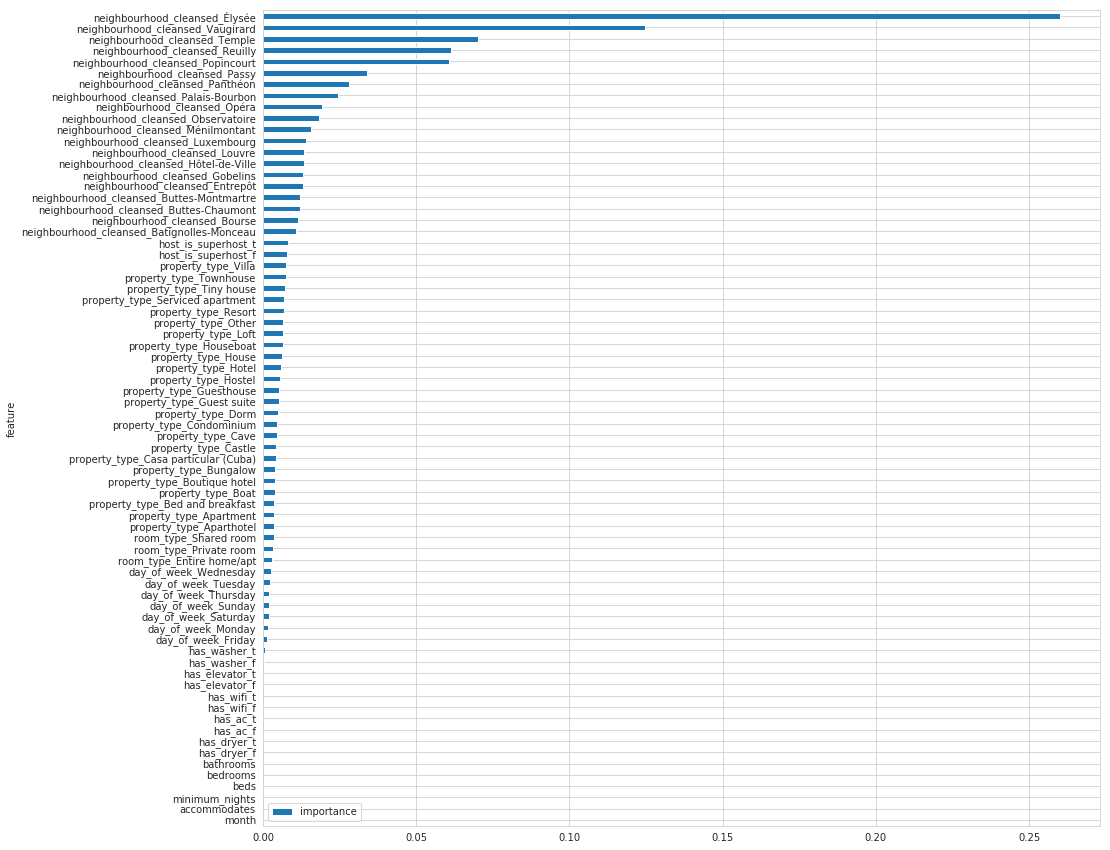

In [1773]:
ax= imp.plot(kind='barh', figsize=(15,15))
plt.savefig('importance_plot.png')

### Linear Regression

In [1774]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
regr = LinearRegression().fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)
regr.coef_
r2_score(y_test,y_pred)

0.45686400343457856

In [1778]:
from sklearn.ensemble import GradientBoostingRegressor

#params = {'n_estimators': 120, 'max_depth': 4, 'min_samples_split': 2,
#          'learning_rate': 0.01, 'loss': 'ls'}
clf = GradientBoostingRegressor(random_state=42)
parameters = {'max_features':range(10,60,10)}
#make scorer
scorer = make_scorer(mean_squared_error)
# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

gb_mod= clf.fit(X_train, y_train)
gb_pred = gb_mod.predict(X_test)
gb_best_pred = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("R2 on testing data: {:.4f}".format(r2_score(y_test, gb_pred)))
print("\nOptimized Model\n------")
print("Final R2 on the testing data: {:.4f}".format(r2_score(y_test, gb_best_pred)))



#clf.fit(X_train, y_train)
#mse = r2_score(y_test, clf.predict(X_test))
#print("MSE: %.4f" % mse)

Unoptimized model
------
R2 on testing data: 0.5183

Optimized Model
------
Final R2 on the testing data: 0.5044
